<a href="https://colab.research.google.com/github/nullzero-live/colab-experiments/blob/main/imageRec-Google-Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

torch.__version__

'1.13.1+cu116'

In [ ]:
#Use for logs and any other items that wouldn't be committed to Github
import os
#from google.colab import drive


 
#MOUNTPOINT = "/content/gdrive"
#DATADIR = os.path.join(MOUNTPOINT, "MyDrive")
#drive.mount(MOUNTPOINT)

In [ ]:
#Retrieve data
!wget -P '/content/gdrive/MyDrive/colab/data/hymenoptera' 'https://download.pytorch.org/tutorial/hymenoptera_data.zip' 

--2023-04-02 02:58:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.7, 13.249.85.22, 13.249.85.10, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/content/gdrive/MyDrive/colab/data/hymenoptera/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  68.8MB/s    in 0.7s    

2023-04-02 02:58:04 (68.8 MB/s) - ‘/content/gdrive/MyDrive/colab/data/hymenoptera/hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip '/content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data.zip' -d '/content/drive/MyDrive/colab/data/hymenoptera'  
data_dir = '/content/drive/MyDrive/colab/data/hymenoptera'

Archive:  /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data.zip
   creating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/
   creating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/
   creating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  


In [ ]:
#Transforms schema
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Create Image Datasets
data_dir = data_dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

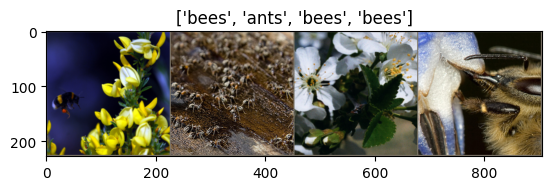

In [ ]:
#Show Image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate

Saving the best model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Generic function to display predictions for a few images



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#Load pretrained model and reset the final fc layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Resnet using hyperparameters

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6659 Acc: 0.6721
val Loss: 0.2371 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.6998 Acc: 0.7377
val Loss: 0.2671 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4648 Acc: 0.7828
val Loss: 0.7510 Acc: 0.7647

Epoch 3/24
----------
train Loss: 0.6259 Acc: 0.7500
val Loss: 0.2103 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5988 Acc: 0.7623
val Loss: 0.2251 Acc: 0.9216

Epoch 5/24
----------


KeyboardInterrupt: ignored

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [ ]:
#Refining a pretrained model, therefore requires grad is set ot False due to weights being 
#set through training.
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

## Fast AI Implementation
https://github.com/fastai/course22/blob/master/09-small-models-road-to-the-top-part-2.ipynb

In [1]:
!pip install "timm>=0.6.2.dev0"
import timm
#With FastAI

from fastai.vision.all import *
set_seed(42)

data_dir = '/content/drive/MyDrive/colab/data/hymenoptera'
tst_files = get_image_files('/content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/val').sorted()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
res = 640,480

In [5]:
models = {
    'convnext_large_in22k': {
        (Resize(res), 224),
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }
}

In [ ]:
trn_path = '/content/drive/MyDrive/colab/data/hymenoptera/hymenoptera_data/val'
files = get_image_files(trn_path)

(500, 375)


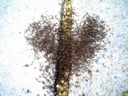

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(500, 375)    31
(500, 333)    31
(500, 334)     5
(375, 500)     5
(500, 376)     3
              ..
(500, 411)     1
(500, 468)     1
(404, 500)     1
(470, 500)     1
(399, 300)     1
Length: 74, dtype: int64

In [ ]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [ ]:
learn = train('resnet18', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.091339,1.890545,0.433333,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.042484,2.104542,0.466667,00:04
1,0.847116,0.639605,0.266667,00:05
2,0.739995,0.847459,0.266667,00:03
3,0.654210,1.288939,0.233333,00:01
4,0.579482,1.231560,0.233333,00:01


A ConvNeXt model

In [ ]:
arch = 'convnext_small_in22k'

In [ ]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:93: UserWarning: Mapping deprecated model convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.674211,0.504445,0.061224,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.168842,0.542977,0.081633,08:30
1,0.140324,0.835846,0.142857,08:23
2,0.109791,1.131776,0.204082,08:21
3,0.101144,1.012301,0.183673,08:35
4,0.081770,0.909035,0.183673,08:23


Preprocessing experiments

In [ ]:
#Worse performance changing the way of cropping/squishing
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

Adding Padding


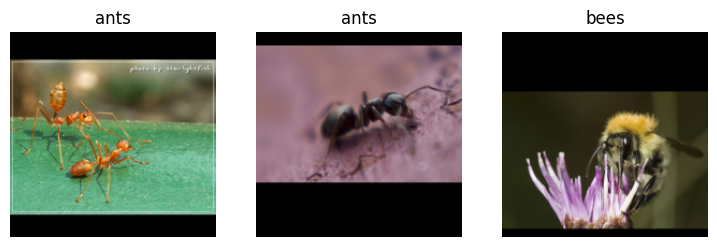

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [ ]:
#Padding added, still not as good as resnet18
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.614830,2.155319,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.872320,1.610140,0.500000,00:03
1,0.841697,1.258010,0.433333,00:06
2,0.707042,0.287630,0.066667,00:02
3,0.597395,0.635546,0.066667,00:02
4,0.479612,0.729341,0.066667,00:05


Test time augmentation

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

TensorBase(0.0667)

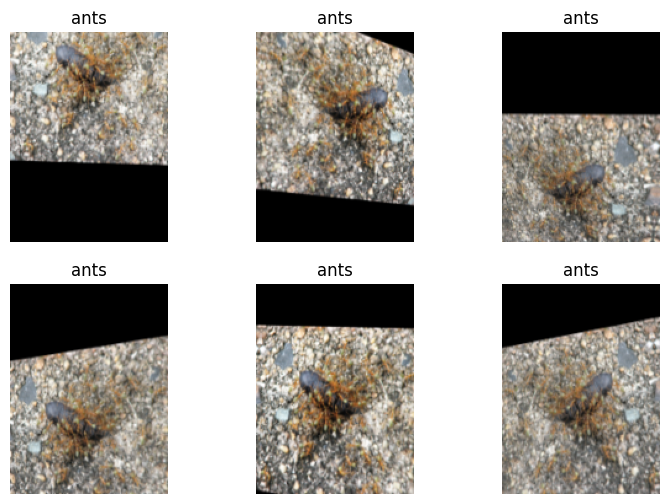

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

TensorBase(0.0667)

Scaling up

In [70]:
#Zero error_rate
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

TypeError: ignored

In [69]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

OutOfMemoryError: ignored

Test 

In [ ]:
preds,_ = learn.tta(dl=tst_dl)
preds

tensor([[1.0000e+00, 3.1411e-12],
        [9.9976e-01, 2.4261e-04],
        [1.0000e+00, 1.3373e-09],
        [1.0000e+00, 1.2697e-24],
        [1.0000e+00, 3.1834e-17],
        [1.0000e+00, 2.0814e-17],
        [9.8675e-01, 1.3248e-02],
        [1.0000e+00, 2.5957e-11],
        [9.9999e-01, 7.7663e-06],
        [1.0000e+00, 3.0918e-14],
        [1.0000e+00, 7.3604e-16],
        [1.0000e+00, 3.5924e-23],
        [1.0000e+00, 1.1463e-20],
        [1.0000e+00, 3.5450e-09],
        [1.0000e+00, 8.7467e-26],
        [1.0000e+00, 7.4390e-20],
        [1.0000e+00, 2.1059e-14],
        [1.0000e+00, 1.0802e-10],
        [1.0000e+00, 2.4173e-09],
        [1.0000e+00, 5.7674e-14],
        [1.0000e+00, 5.3543e-19],
        [1.0000e+00, 3.5756e-11],
        [9.9607e-01, 3.9311e-03],
        [9.9980e-01, 2.0100e-04],
        [1.0000e+00, 5.4695e-16],
        [1.0000e+00, 9.8400e-15],
        [1.0000e+00, 5.1497e-16],
        [1.0000e+00, 3.4721e-09],
        [1.0000e+00, 9.6815e-15],
        [9.283

In [ ]:
idxs = preds.argmax(dim=1)

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
results

0      ants
1      ants
2      ants
3      ants
4      ants
       ... 
148    bees
149    bees
150    bees
151    bees
152    bees
Name: idxs, Length: 153, dtype: object

## Part 3
https://github.com/fastai/course22/blob/master/10-scaling-up-road-to-the-top-part-3.ipynb

In [ ]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [ ]:
train('convnext_small_in22k', 128, epochs=4, accum=1, finetune=False)

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:93: UserWarning: Mapping deprecated model convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.683823,3.965229,0.666667,00:04
1,1.778286,3.088956,0.700000,00:07
2,1.773078,6.302298,0.666667,00:04
3,1.950797,5.940217,0.666667,00:06


In [ ]:
!pip install pynvml
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.5 MB/s eta 0:00:00


In [ ]:
report_gpu()

GPU:0
process      17289 uses     2962.000 MB GPU memory


Increase Accum to 4

In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,1.343659,1.076155,0.466667,00:06


GPU:0
process      17289 uses     5182.000 MB GPU memory


In [ ]:
train('vit_large_patch16_224', 224, epochs=1, accum=2, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.916334,0.714966,0.300000,00:05


GPU:0
process      17289 uses    13936.000 MB GPU memory


Running Models

In [ ]:
res = 640,480

In [ ]:
models = {
    'convnext_large_in22k': {
        (Resize(res), 224),
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }
}

In [ ]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:93: UserWarning: Mapping deprecated model convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.823538,20.221619,0.700000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.321740,7.187751,0.633333,00:06
1,0.211347,0.081669,0.033333,00:04
2,0.214066,0.367664,0.033333,00:04
3,0.196500,0.049549,0.033333,00:05
4,0.158336,0.127080,0.033333,00:04
5,0.137541,0.061308,0.033333,00:05
6,0.115466,0.016844,0.000000,00:05
7,0.108306,0.000232,0.000000,00:04
8,0.093312,0.000117,0.000000,00:04
9,0.081278,0.000051,0.000000,00:05


--- convnext_large_in22k
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.983165,7.449817,0.633333,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.153504,1.923619,0.266667,00:04
1,0.088746,0.000429,0.000000,00:04
2,0.070003,0.001046,0.000000,00:04
3,0.056563,0.000210,0.000000,00:05
4,0.045550,0.000169,0.000000,00:04
5,0.043515,0.000136,0.000000,00:04
6,0.039353,0.000169,0.000000,00:04
7,0.047572,0.000093,0.000000,00:03
8,0.047842,0.000061,0.000000,00:04
9,0.051939,0.000030,0.000000,00:08


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,1.054018,0.001794,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time


OutOfMemoryError: ignored

### Using Transformers Library For Model Selection (model load failed due to FastAI backend code)

In [ ]:
'''DELETED THIRD LINE FOR REFERENCEdls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75),
    )
    

dls.show_batch(max_n=6)'''

In [ ]:

#!pip install transformers
#from transformers import AutoModel



In [ ]:
#learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
#learn.fine_tune(8, 0.01)